# Isochoric Experiments

## Thermodynamics Analysis
Computes T_2 and P_2 for closed system isochoric reaction based on moles of Al + H20

Documentation:
- http://www.coolprop.org/coolprop/LowLevelAPI.html
- http://www.coolprop.org/coolprop/HighLevelAPI.html

In [1]:
import matplotlib

# plotting directives
matplotlib.rcParams['axes.labelsize'] = 13
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 13
matplotlib.rcParams['figure.autolayout'] = True
matplotlib.rcParams['savefig.transparent'] = False
matplotlib.rcParams['savefig.facecolor'] = (1, 1, 1, 1)
#matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']

In [2]:
import nasaPoly
import CoolProp.CoolProp as cp
from scipy.optimize import fsolve, least_squares
import numpy as np
from simulation_util import *

## Set reference state of CoolProp to match nasaPoly
cp.set_reference_state('Water', 298.15, \
        cp.PropsSI('Dmolar', 'T', 298.15, 'P', 101325, 'Water'), \
        -285.830e3, 69.93905786241871)
cp.set_reference_state('Hydrogen', 298.15, \
        cp.PropsSI('Dmolar', 'T', 298.15, 'P', 101325, 'Hydrogen'), \
        0, 130.68085677983967)
cp.set_reference_state('Air', 298.15, \
        cp.PropsSI('Dmolar', 'T', 298.15, 'P', 101325, 'Air'), \
        0, 198.8222014069401)

# creates objects for each species
Water = cp.AbstractState('HEOS', 'Water')
Hydrogen = cp.AbstractState('HEOS', 'Hydrogen')
Air = cp.AbstractState('HEOS', 'Air')
Al = nasaPoly.Species('AL(cr)')
AlOH3 = nasaPoly.Species('AL(OH)3(a)') # I need AlOOH for this reaction
O2 = nasaPoly.Species('O2')
H2 = nasaPoly.Species('H2')
Ar = nasaPoly.Species('Ar')

# Aux functions:
v_al = 1e-5 # m^3/mol
v_aloh3 = 1/2420*(AlOH3.molecular_wt*1e-3) # m^3/mol
v_alooh = 1/3010*(59.99e-3) # m^3/mol
h_alooh = lambda T: (-1.044e-09*T**4 + 1.82e-06*T**3 - 0.001133*T**2 + 0.2943*T - \
                     1023)*1E3 + O2.h_0(T) + 0.5*H2.h_0(T) + Al.h_0(T)
u_alooh = lambda T, P: h_alooh(T) - P*v_alooh
u_al = lambda T, P: Al.h_0(T) - P*v_al
u_aloh3 = lambda T, P: AlOH3.h_0(T) - P*v_aloh3

M_al = 26.981539e-3 # kg/mol
H_fg_water = 40.8e3 # J/mol
M_water = 18.01528e-3 # kg/mol

# Define function to take in inputs, and compute terms in first law
# Given input parameters and moles of Al and H20, what is the maximum temp and pressure?
#P_1 = 101325; # [Pa], Pressure in state 1 (ambient)
#T_1 = 298.15; # [K], Temperature in state 1 (ambient)
#V_1 = 120e-6; # [m^3], Volume of vessel (isochoric)
#n_al [moles], moles of aluminum added to reaction chamber
#n_h20 [moles], moles of H20 added to reaction chamber


def compute_reactivity(m_al, m_h2o, P_final, T_final, V_reactor, P_initial):
    #print(f'Computing reactivity for m_al={m_al} kg, m_h2o={m_h2o} kg, P_final={P_final} Pa, T_final={T_final} K, V_reactor={V_reactor*1e3} L, P_initial={P_initial} Pa')
    if abs(P_final - 101325) < 0.5e5:
        return 0
    n_h2o = m_h2o/M_water - 2*(m_al/M_al)
    n_h2_expected = 1.5*(m_al/M_al) # moles
    # Compute quality
    Water.update(cp.QT_INPUTS, 1, T_final)
    v_g = 1/Water.rhomolar()
    Water.update(cp.QT_INPUTS, 0, T_final)
    v_f = 1/Water.rhomolar()
    x_h2o = (V_reactor/n_h2o - v_f)/(v_g - v_f)
    if x_h2o >= 1:
        Water.update(cp.DmolarT_INPUTS, n_h2o/V_reactor, T_final)
        V_final = V_reactor # Gas volume
    else:
        Water.update(cp.QT_INPUTS, 0, T_final)
        V_final = V_reactor - n_h2o*(1-x_h2o)/Water.rhomolar()
        Water.update(cp.QT_INPUTS, x_h2o, T_final)
    # Compute partial pressure of H2
    P_h2o = Water.p()
    P_air = P_initial + 10132 #Pa
    P_h2 = P_final - P_h2o - P_air
    #print(f'P_h2o={P_h2o*1e-5:.3g} bar\nV_final={V_final*1e6:.3g} mL')
    Hydrogen.update(cp.PT_INPUTS, P_h2, T_final)
    n_h2_actual = Hydrogen.rhomolar()*V_reactor # moles
    return n_h2_actual / n_h2_expected
    

In [3]:
# Spot check:
print(compute_reactivity(0.29624*1e-3, 17.5e-3, (472*0.0689475729 + 1)*1e5, 297.9, 96e-6, (401.76*0.0689475729 + 0*1)*1e5))

print(u_al(300, 1e5), u_alooh(300, 1e5), u_aloh3(300, 1e5))

1.1260861838532514
43.80172119933395 -995872.5534859936 -1293331.0649845563


In [4]:
def compute_reactivity2(m_al, m_h2o, P_final, T_final, V_reactor, P_initial):
    #print(f'Computing reactivity for m_al={m_al} kg, m_h2o={m_h2o} kg, P_final={P_final} Pa, T_final={T_final} K, V_reactor={V_reactor*1e3} L, P_initial={P_initial} Pa')
    if abs(P_final - 101325) < 0.5e5:
        return 0
    n_h2o = m_h2o/M_water - 2*(m_al/M_al)
    #n_h2o = m_h2o/M_water
    n_h2_expected = 1.5*(m_al/M_al) # moles
    # Compute quality
    Water.update(cp.QT_INPUTS, 1, T_final)
    v_g = 1/Water.rhomolar()
    Water.update(cp.QT_INPUTS, 0, T_final)
    v_f = 1/Water.rhomolar()
    x_h2o = (V_reactor/n_h2o - v_f)/(v_g - v_f)
    if x_h2o >= 1:
        Water.update(cp.DmolarT_INPUTS, n_h2o/V_reactor, T_final)
        V_final = V_reactor # Gas volume
    else:
        Water.update(cp.QT_INPUTS, 0, T_final)
        V_final = V_reactor - n_h2o*(1-x_h2o)/Water.rhomolar()
        Water.update(cp.QT_INPUTS, x_h2o, T_final)
    # Compute partial pressure of H2
    P_h2o = Water.p()
    #print(P_initial)
    #P_air = P_initial + 101325# Pa
    P_h2 = P_final - P_initial - P_h2o
    #print(f'P_h2o={P_h2o*1e-5:.3g} bar\nP_h2={P_h2*1e-5:.3g} bar\nV_final={V_final*1e6:.3g} mL')
    Hydrogen.update(cp.PT_INPUTS, P_h2, T_final)
    #print(Hydrogen.rhomolar())
    n_h2_actual = Hydrogen.rhomolar()*V_reactor # moles
    n=P_h2*V_reactor/(8.314*T_final)
    #print(n)
    #print(f'P_h2o={P_h2o*1e-5:.3g} bar\nP_h2={P_h2*1e-5:.3g} bar')
    return n / n_h2_expected
    
print(compute_reactivity2(0.32*0.92*1e-3, 20e-3, (94*0.0689475729 + 0*1)*1e5, 315, 83e-6, (20*0.0689475729 + 0*1)*1e5))

0.9722026857078916


# Data processing

In [5]:
import os
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

data_folder = '../data/'
process_dirs = ['folder_name']

T_max_vec = []
P_max_vec = []
V_h2o_1_vec = []
m_al_vec = []
reactivity_vec = []

filter_P = True
correct_offset = False

trials = []

def butter_lowpass_filter(data, cutoff, fs=5, order=3):
    nyq = 0.5*fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

class Trial:
    def __init__(self, data_filepath, m_al, m_h2o_1, P_init, t_data, P_data, T2_data, reactor_version='V2', \
                 filter_P=True, correct_P_offset=True, pH=7, plot_data=True, medium='air', solution_name='H2O'):
        self.V_reactor = {'V2': 130e-6, 'V3': 55e-6, 'V4':77.5e-6}[reactor_version]
        self.data_filepath = data_filepath
        self.data_filename = data_filepath.split('/')[-1]
        self.data_parent_folder = data_filepath.split('/')[-2]
        self.m_al = m_al # kg
        self.m_h2o_1 = m_h2o_1 # kg
        self.P_init = P_init #psi
        self.t = t_data
        self.T2 = T2_data
        self.P_raw = P_data
        self.P = P_data
        self.medium = medium
        self.solution_name = solution_name
        #self.al_fraction = 0.298/0.315
        self.al_fraction = 0.92
        if filter_P == True:
            self.P = butter_lowpass_filter(P_data, 0.1)
        if correct_P_offset == True:
            num_samples = 10
            P_offset = sum(P_data[0:num_samples])/num_samples - 1.01325 # Bar
            print(f'Corrected offset of {P_offset:.3g} bar')
            self.P = self.P - P_offset
        self.reactor_version = reactor_version
        self.reactivity = compute_reactivity(m_al*self.al_fraction, m_h2o_1, self.P[-1]*1e5, self.T2[-1]+273.15, self.V_reactor, P_init)
        P_error = 3000*(0.25/100)*0.0689475729 # Bar
        self.pH = pH
        print(f'V_h2o_1={m_h2o_1*1e3} mL; m_al={m_al*1e3} g; Reactor version: {reactor_version}')
        if plot_data == True:
            self._show_plot()
        print(f'Max pressure: {max(self.P)} bar (P_h2_stoich~={m_al/27*1.5*8.314*294.15/130e-6*1e-5} bar)')
        print(f'Max temperature: {max(self.T2)+273.15} K')
        print(f'Final pressure: {self.P[-1]} bar')
        print(f'Computed reactivity: {self.reactivity}')
        print('==================================\n')
        
    def _show_plot(self):
        fig, (a1,a2) = plt.subplots(2)
        a1.plot(self.t/(60e3), self.P_raw)
        a1.plot(self.t/(60e3), self.P)
        a1.set(xlabel='Time [min]', ylabel='Pressure [bar]')
        #a2.plot(t, T1)
        a2.plot(t/(60e3), self.T2)
        #a2.plot(t/(60e3), T2_filt)
        a2.set(xlabel='Time [min]', ylabel='Temperature [degC]')
        plt.show()
        
def process_data_file(filepath):
    #print(f'>>>>> {filename.split("/")[-1]} >>>>>')
    print(f'>>>>> {filepath} >>>>>')
    filetype = filepath.split('.')[-1]
    filename = filepath.split('/')[-1]
    parms = filename.split('.'+filetype)[0].split('_')
    V_h2o_1 = float(parms[3].split('mL')[0])
    m_al = float(parms[2].split('mg')[0])*1e-3
    P_init = float(parms[5].split('psi')[0])
    solution_name = str(parms[4])
    if 'ph' in filename:
        reactor_version = parms[2]
        pH = float(parms[3].split('ph')[1])
    else:
        pH = 7.0
        #reactor_version = parms[2].split('.')[0]
        reactor_version = 'V4'
    if 'ar' in filename or 'Ar' in filename:
        medium='argon'
    else:
        medium='air'
    #print(f'File: {data_folder+date+filename}')
    #print(f'V_h2o_1={V_h2o_1} mL; m_al={m_al} g; Reactor version: {reactor_version}')
    if 'xls' in filetype:
        data = pandas.read_excel(data_folder+date+filename, usecols='A:D')
    else:
        with open(filepath, 'r') as f:
            max_header = 100
            i = 0
            while '=' not in f.readline():
                if i > max_header:
                    f.seek(0, 0)
                    break
                else:
                    i += 1
                    pass
            data = pandas.read_csv(f, skipinitialspace=True)
            #print(data.keys())
    t = data['Time'].to_numpy()
    P = data['Pressure'].to_numpy()*0.0689475729 + 1.01325 # Bar absolute
    P_filt = butter_lowpass_filter(P, 0.1)
    T2 = data['T2'].to_numpy()
    try:
        T1 = data['T1'].to_numpy()
    except KeyError:
        T1 = np.array([0 for T in T2])
    trial = Trial(filepath, m_al*1e-3, V_h2o_1*1e-3, P_init*6894.757293, t, P, T2, reactor_version=reactor_version, plot_data=False, pH=pH, medium=medium, solution_name=solution_name)
    return(trial)

for d in process_dirs:
    # Filename format 'XXmL_YYg_VZ.xlsx' for XX mL input water, YY g of input fuel, and reactor setup version Z
    d = d.split('/')[0]+'/'
    for filename in sorted(os.listdir(data_folder+d)):
        if '~' in filename or filename[0] == '.':
            continue
        path = data_folder+d+filename
        if os.path.isdir(path):
            continue
        if not 'bb' in filename:
            continue
        trial = process_data_file(path)
        if trial.reactor_version == 'V1':
            continue
        trials.append(trial)

>>>>> ../experimental_data/high_pressure_experiments/caffeine2/20220801_bb_325mg_15mL_3MNaCl_58.65psi_1.csv >>>>>
Corrected offset of -2.22e-16 bar
V_h2o_1=15.0 mL; m_al=0.32500000000000007 g; Reactor version: V4
Max pressure: 9.932414645955372 bar (P_h2_stoich~=0.0033966154166666673 bar)
Max temperature: 301.4 K
Final pressure: 9.909117498632767 bar
Computed reactivity: 1.1104044603927

>>>>> ../experimental_data/high_pressure_experiments/caffeine2/20221001_bb_326mg_15mL_3MNaCl-and-0.01MCaffeine_79.18psi_1.csv >>>>>
Corrected offset of -2.22e-16 bar
V_h2o_1=15.0 mL; m_al=0.326 g; Reactor version: V4
Max pressure: 11.789727946784005 bar (P_h2_stoich~=0.0034070665410256416 bar)
Max temperature: 316.65 K
Final pressure: 11.543483396520774 bar
Computed reactivity: 1.138036964527222

>>>>> ../experimental_data/high_pressure_experiments/caffeine2/20221002_bb_327mg_15mL_DI_20.53psi_2.csv >>>>>
Corrected offset of -2.22e-16 bar
V_h2o_1=15.0 mL; m_al=0.327 g; Reactor version: V4
Max pressure: 

# Graphs

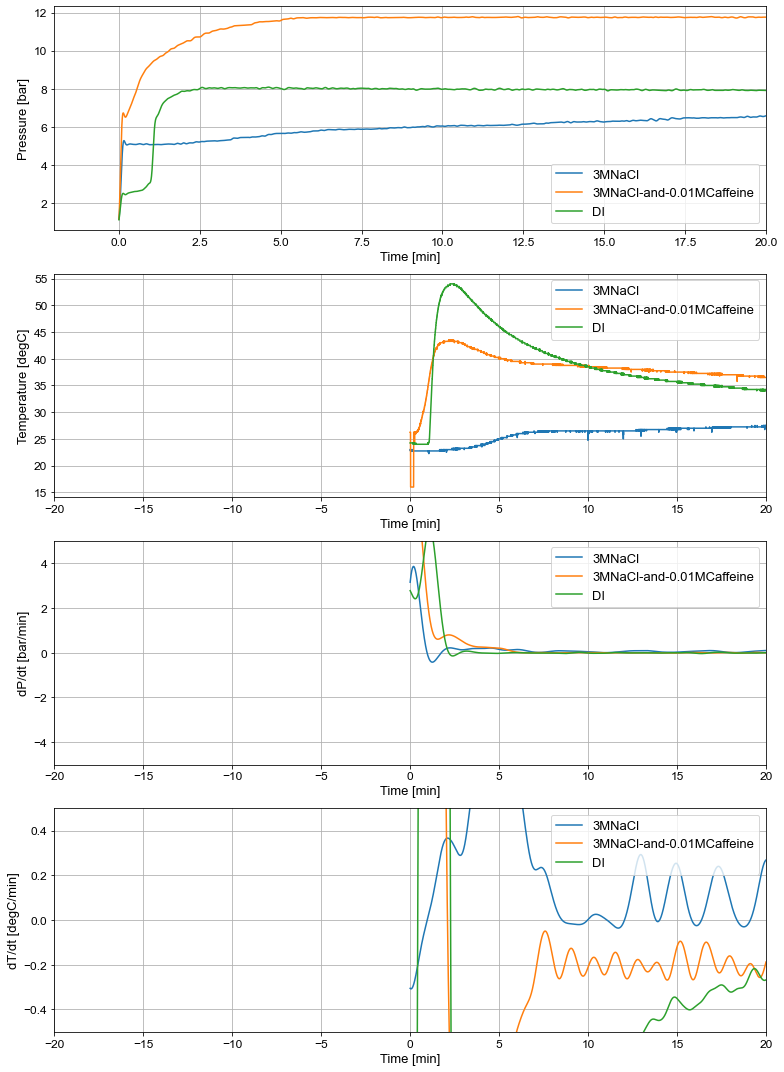

In [6]:
def plot_all(trial_vec):
    fig, (a1, a2, a3, a4) = plt.subplots(4)
    for trial in trial_vec:
        # find first index where the pressure starts to rise
        for j, P in enumerate(trial.P):
            if P > 1.1:
                break
        P_plot = trial.P[j:]
        T_plot = trial.T2[j:]
        tau_s = 0.2 # seconds
        t_vec = np.linspace(0, tau_s*(len(P_plot))/60, len(P_plot)) # minutes
        a1.plot(t_vec, P_plot, label=trial.solution_name) 
        a2.plot(t_vec, T_plot, label=trial.solution_name)
        a3.plot(t_vec[1:], butter_lowpass_filter([(P_plot[i]-P_plot[i-1])/(t_vec[i] - t_vec[i-1]) for i in range(1, len(t_vec))], 0.01), \
                label=trial.solution_name) 
        a4.plot(t_vec[1:], butter_lowpass_filter([(T_plot[i]-T_plot[i-1])/(t_vec[i] - t_vec[i-1]) for i in range(1, len(t_vec))], 0.01), \
                label=trial.solution_name) 
    a1.set(xlabel='Time [min]',ylabel='Pressure [bar]')
    a2.set(xlabel='Time [min]',ylabel='Temperature [degC]')
    a3.set(xlabel='Time [min]',ylabel='dP/dt [bar/min]')
    a4.set(xlabel='Time [min]', ylabel='dT/dt [degC/min]')
    a1.legend(loc='lower right')
    a2.legend(loc='upper right')
    a3.legend(loc='upper right')
    a4.legend(loc='upper right')
    t_upper = 20
    a1.set_xlim([-2, t_upper])
    a2.set_xlim([-20, t_upper])
    a3.set_xlim([-20, t_upper])
    a3.set_ylim([-5, 5])
    a4.set_xlim([-20, t_upper])
    a4.set_ylim([-0.5, 0.5])
    a1.grid()
    a2.grid()
    a3.grid()
    a4.grid()
    plt.gcf().set_size_inches(11,15)
    #plt.tight_layout()
    #a1.set_title(f'{trial_vec[0].m_al*1e3} g Al')
    #fig.savefig('./fig/all_caff.png', dpi=300)
    plt.show()
    
#plot_trials = [T for T in trials if T.m_al==0.945e-3 and T.pH==7]
plot_trials = trials
plot_all(plot_trials)

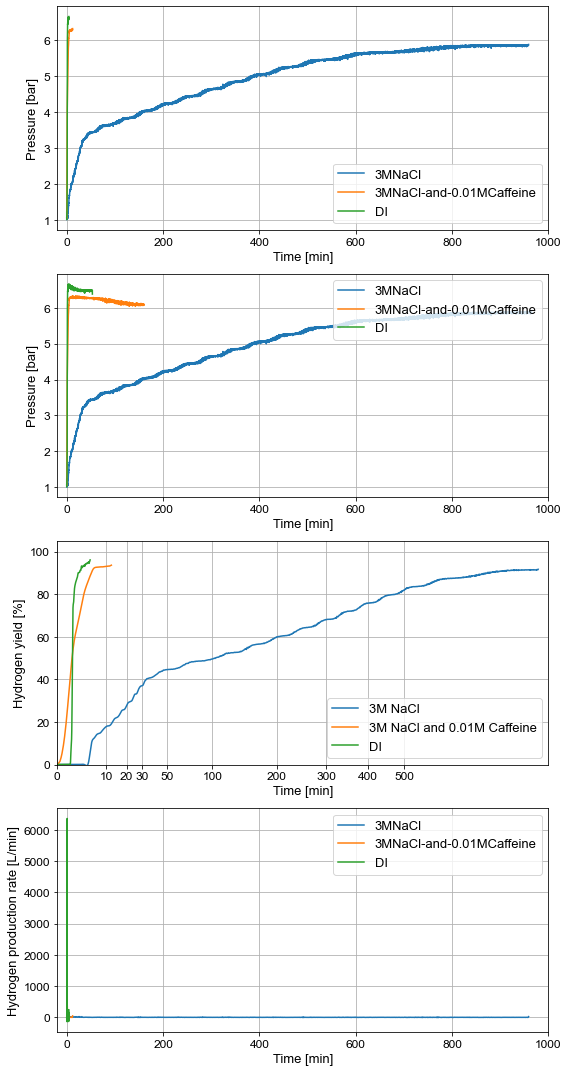

In [11]:
def plot_h2(trial_vec):
    fig, (a1, a2, a3, a4) = plt.subplots(4)
    t_upper = 500
    for trial in trial_vec:
        t_upper = 2000
        # find first index where the pressure starts to rise
        for j, P in enumerate(trial.P):
            #print(trial.P_init)
            if P > trial.P_init*0.00001+1.01325:
                break
        P_plot = trial.P[j:]-trial.P_init*0.00001
        maxi=np.where(P_plot==max(P_plot))
        Pmax=max(P_plot)
        maxP=int(maxi[0])
        P2_plot=P_plot[0:int(maxi[0])]
        T_plot = trial.T2[j:]
        T2_plot=T_plot[0:int(maxi[0])]
        tau_s = 0.2 # seconds
        t_vec2 = np.linspace(0, tau_s*(len(P2_plot))/60, len(P2_plot)) # minutes
        a1.plot(t_vec2, P2_plot, label=trial.solution_name) 
        t_vec = np.linspace(0, tau_s*(len(P_plot))/60, len(P_plot)) # minutes
        a2.plot(t_vec, P_plot, label=trial.solution_name)
        H2_plot=[]
        t_vec3=[]
        V2_plot=[]
        n_h2_expected = 1.5*(trial.m_al/M_al) # moles
        for i in range(0,maxP,10):
            reac=compute_reactivity(trial.m_al*trial.al_fraction, trial.m_h2o_1, P2_plot[i]*1e5, T2_plot[i]+273.15, trial.V_reactor, 0)
            H2_plot.append(reac*100)
            t_vec3.append(t_vec2[i])
            n_h2=reac*n_h2_expected
            V_h2=n_h2/4.528 #L
            V2_plot.append(V_h2*1000)
        a3.plot(t_vec3, butter_lowpass_filter(H2_plot, 0.1), label=trial.solution_name)
        #a4.plot(t_vec3, V2_plot, label=trial.solution_name)
        a4.plot(t_vec3[1:], butter_lowpass_filter([(V2_plot[i]-V2_plot[i-1])/((t_vec3[i] - t_vec3[i-1])*tau_s/60) for i in range(1, len(t_vec3))], 0.1), \
                label=trial.solution_name) 
        

    a1.set(xlabel='Time [min]',ylabel='Pressure [bar]')
    a2.set(xlabel='Time [min]',ylabel='Pressure [bar]')
    a3.set(xlabel='Time [min]',ylabel='Hydrogen yield [%]')
    a4.set(xlabel='Time [min]',ylabel='Hydrogen production rate [L/min]')

    a1.legend(loc='lower right')
    a2.legend(loc='upper right')
    a3.legend(loc='lower right')
    a4.legend(loc='upper right')

    t_upper = 1000
    a1.set_xlim([-20, t_upper])
    a2.set_xlim([-20, t_upper])
    a3.set_xlim([0, t_upper])
    a3.set_ylim([0, 105])
    
    f = lambda a: np.sqrt(a)
    g = lambda b: b**2
    a3.set_xscale('function', functions=(f, g))
    
    from matplotlib.ticker import FixedLocator
    # Calculate custom x-ticks and labels
    x_ticks = np.arange(0, 31, 10).tolist()  # Up to 100, every 10
    x_ticks += [50, 100, 200, 300, 400, 500]
    
    # Apply the custom x-ticks and labels
    #a3.set_xticks(x_ticks)
    #ax.set_xticklabels(x_labels)
    a3.xaxis.set_major_locator(FixedLocator(x_ticks))

    a4.set_xlim([-20, t_upper])
    a4.set_ylim([-0.5, 0.5])
    a1.grid()
    a2.grid()
    a3.grid()
    a4.grid()
    plt.gcf().set_size_inches(8,15)
    plt.show()
    #fig.savefig('./fig/h2_caff2.png', dpi=300)
    
    
plot_trials = trials
plot_h2(plot_trials)